In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Fonction d'impureté

In [2]:
def gini(C,classes):
    """Calcul le coefficient de Gini associée à l'ensemble"""
    N = C.shape[0]
    res = 0
    for i in classes:
        pi = (C==i).sum()/N
        res += pi*(1 - pi)
    return res

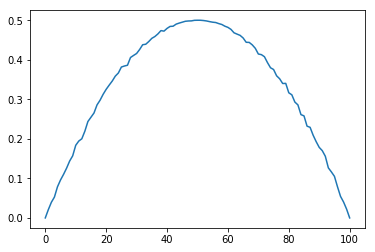

In [3]:
# Vérification de la fonction qui calcule le coefficient de Gini
L = []
for p in [0.01*j for j in range(101)]:
    X = np.random.binomial(1,p,size=10000)
    L.append(gini(X,[0,1]))
plt.plot(L)

### Minimisation de la fonction d'impureté

In [4]:
def minimise_impurete(X,C,classes, impurete=gini):
    """Calcul le meilleur treshold pour séparer deux ensembles"""
    m = X.shape[1]
    gain_purete = 0
    best_treshold = X[0,0]
    best_indice = 0
    # On parcourt tout les features possibles
    for i in range(m):
        # On test différents treshold parmis les valeurs qui existent
        for t in list(X[:,i]):
            # On partage en deux sous ensemble selon le critère testé
            CL = C[X[:,i]<= t ]
            CR = C[X[:,i] > t ]
            piL = CL.shape[0]/C.shape[0]
            piR = CR.shape[0]/C.shape[0]
            
            # Calcul du gain en pureté
            new_gain = impurete(C,classes) - (piL*impurete(CL,classes) + piR*impurete(CR,classes))
            
            # On sélectionne le meilleure critère pour partager notre dataset, i.e. celui qui maximise le gain en pureté
            if (new_gain > gain_purete):
                best_treshold = t
                best_indice = i
                gain_purete = new_gain
    return best_indice,best_treshold
            

/home/kronert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


(1, 0.498418410221838)

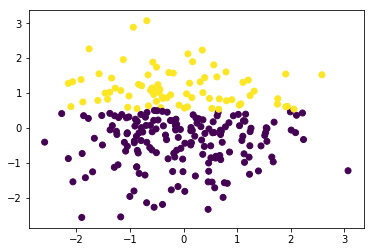

In [5]:
# Test de la fonction de minimisation de l'impurete
Y = np.random.randn(500).reshape((-1,2))
C = Y[:,1]>0.5
plt.scatter(Y[:,0],Y[:,1],c=C)
minimise_impurete(Y,C,[0,1], impurete=gini)

### Arbre de classification

In [24]:
class node():
    """Classes correspondant aux noeuds de l'arbre"""
    def __init__(self, X, C, classes, impurete=gini, min_leave=2,min_impur=1e-5):
        # On calcul la meilleure façon de partager notre noeuds
        self.ind, self.treshold = minimise_impurete(X,C,classes,impurete)
        XL,CL = X[X[:,self.ind]<= self.treshold],C[X[:,self.ind]<= self.treshold]
        XR,CR = X[X[:,self.ind] > self.treshold],C[X[:,self.ind] > self.treshold]
        
        # Sous arbre de gauche
        if CL.shape[0] <= min_leave or impurete(CL, classes)<min_impur: #critère d'arrët
            self.nodeL = leave(XL,CL,classes)
        else:
            self.nodeL = node(XL,CL,classes, impurete,min_leave, min_impur) #Récursivité
            
        # Sous arbre de droite
        if CR.shape[0] <= min_leave or impurete(CR, classes)<min_impur: #critère d'arrët
            self.nodeR = leave(XR,CR,classes)
        else:
            self.nodeR = node(XR,CR,classes, impurete,min_leave, min_impur) # Récursivité
            
    def predict(self, x):
        # en fonction de la réponse à la question, on descend dans l'arbre de gauche ou de droite
        if x[self.ind]<self.treshold:
            return self.nodeL.predict(x)
        return self.nodeR.predict(x)
    def affichage(self, n):
        self.nodeL.affichage(n+1)
        print("   "*n, self.ind,":",self.treshold)
        self.nodeR.affichage(n+1)

In [25]:
class leave():
    """Classe corresondant à la feuille d'un arbre"""
    def __init__(self,X,C,classes):
        # On cherche la classe la plus représentées dans la feuille
        reprt = 0
        nb_repr = 0
        for i in classes:
            new_repr_nb = (C==i).sum()
            if new_repr_nb > nb_repr:
                nb_repr = new_repr_nb
                reprt = i
        self.represantant = reprt
    def predict(self,x):
        # La résultat renvoyé par la feuille sera remonté en haut de l'arbre par récursivité
        return self.represantant
    def affichage(self, n):
        print("   "*n, self.represantant)

In [26]:
class tree():
    """classe correspondant à un arbre de décision"""
    def __init__(self, X, C, classes, impurete=gini, min_leave=2, min_impur=1e-5):
        # On construit le premier noeud en racine, le reste est construit par récurcivité
        self.root = node(X, C, classes, impurete, min_leave, min_impur)
    
    def predict(self,x):
        return self.root.predict(x)
    
    def predict_multiple(self, X):
        """ Permet d'effectuer des prédictions sur une liste de d'éléments"""
        L = []
        for x in list(X):
            L.append(self.predict(x))
        return np.array(L)
    def affichage(self):
        self.root.affichage(0)

### Test sur un ensemble fictif

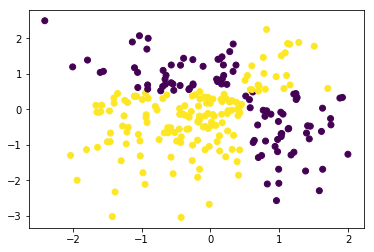

In [45]:
# Test de l'arbre de classification
Y = np.random.randn(500).reshape((-1,2))
C = np.zeros(Y.shape[0])
C[(Y[:,1]>0.5)*(Y[:,0]>0.5)] = 1
C[(Y[:,1]<=0.5)*(Y[:,0]<=0.5)] = 1
plt.scatter(Y[:,0],Y[:,1],c=C)

/home/kronert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


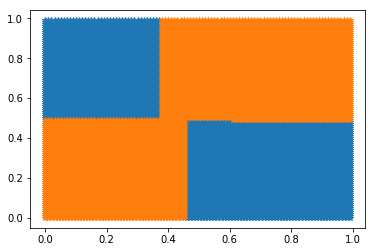

In [46]:
clf = tree(Y,C,[0,1])
X = [[(x*0.01,y*0.01) for x in range(100)] for y in range(100)]
X = np.array(X)

X = X.reshape((-1,2))
plt.plot(X[clf.predict_multiple(X)==0,0],X[clf.predict_multiple(X)==0,1],'*')
plt.plot(X[clf.predict_multiple(X)==1,0],X[clf.predict_multiple(X)==1,1],'*')

In [47]:
clf.affichage()

          1
       0 : 0.45106051215021004
          0
    1 : 0.495612122643744
          0
       0 : 0.3712809392634918
          1
 0 : 0.6040988998884436
       0
    1 : 0.48536475162834997
       1


### Test sur le iris_set

In [36]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
C = iris['target']
classes = [0,1,2]

In [37]:

choose = np.random.binomial(1,.5,size=150)
choose = (choose==1)
clf = tree(X[choose],C[choose],classes)
(clf.predict_multiple(X)==C).sum()/150

/home/kronert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


0.9066666666666666

In [38]:
clf.affichage()

    0
 2 : 1.9
       1
    2 : 4.7
       2


### Test sur le wine set

In [51]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine['data']
C = wine['target']
classes = [0,1,2]
X.shape

(178, 13)

In [52]:
choose = np.random.binomial(1,.5,size=178)
choose = (choose==1)
clf = tree(X[choose],C[choose],classes)
(clf.predict_multiple(X)==C).sum()/178

/home/kronert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


0.9382022471910112

In [53]:
clf.affichage()

       2
    6 : 0.47
          1
       12 : 937.0
          0
 9 : 3.94
       2
    6 : 1.57
          1
       1 : 1.21
          0


### Random Forest

In [72]:
class RandomForest():
    """Classe représantant une foret aléatoire"""
    
    def __init__(self, X, C, classes,
                 nbTree, nbVariables, bagging_proba=0.3,
                 impurete=gini, min_leave=2,min_impur=1e-5):
        
        self.nbTree = nbTree
        self.Foret = []
        self.var_selec = []
        self.classes = classes
        self.var_num = X.shape[1]
        
        # Pour chaque arbre
        for _ in range(nbTree):
            # On bootstrap une sous partie de nos données
            choose = np.random.binomial(1,bagging_proba,size=X.shape[0])
            choose = (choose==1)
            X_boot = X[choose]
            C_boot = C[choose]
            # On sélectionne un certain nombre de variable à prendre en compte
            var_boot = np.zeros(X.shape[1])
            var_boot[np.random.choice(range(X.shape[1]),size=nbVariables,replace=False)] = 1
            var_boot = (var_boot==1)
            # On ajoute l'arbre à notre forêt
            self.Foret.append(tree(X_boot[:,var_boot], C_boot,classes, impurete, min_leave,min_impur))
            self.var_selec.append(var_boot)
    
    def vote(self, x):
        """ Chaque arbre de la forêt vote pour une classe"""
        res_vote = np.zeros(len(self.classes))
        
        for i in range(self.nbTree):
            res_vote[self.Foret[i].predict(x[self.var_selec[i]])] += 1
        return res_vote
    
    def predict(self, x):
        """Renvoie la classe prédite par la forêt, i.e. celle qui résulte du vote majoritaire"""
        return np.argmax(self.vote(x))
    
    def predict_multiple(self, X):
        L = []
        for x in list(X):
            L.append(self.predict(x))
        return np.array(L)
    def affichage(self):
        for i in range(self.nbTree):
            print("arbre num.",i)
            print(np.arange(self.var_num)[self.var_selec[i]])
            self.Foret[i].affichage()
            print("")

### Test sur le wine dataset

In [73]:
wine = load_wine()
X = wine['data']
C = wine['target']
classes = [0,1,2]
X.shape

(178, 13)

In [74]:
choose = np.random.binomial(1,.5,size=178)
choose = (choose==1)
clf = RandomForest(X[choose],C[choose],classes,100,3)
(clf.predict_multiple(X)==C).sum()/178

/home/kronert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


0.9831460674157303

In [75]:
clf.affichage()

arbre num. 0
[ 1  2 12]
             1
          0 : 1.25
             2
       0 : 1.35
          1
    0 : 2.4
             2
          0 : 3.83
                1
             1 : 2.4
                2
       0 : 4.3
          2
 2 : 750.0
    0

arbre num. 1
[0 2 7]
             1
          1 : 2.16
             2
       2 : 0.29
          1
    1 : 2.56
          1
       0 : 11.81
          2
 0 : 13.03
             0
          0 : 13.07
             1
       1 : 2.13
                0
             0 : 13.05
                2
          0 : 13.5
             0
    2 : 0.47
       2

arbre num. 2
[ 3  5 11]
       1
    0 : 16.8
          2
       1 : 2.32
          1
 2 : 2.31
       1
    1 : 2.36
             0
          2 : 3.36
             0
       1 : 3.25
          1

arbre num. 3
[2 6 9]
    1
 2 : 3.74
       2
    1 : 1.1
          1
       0 : 2.1
          0

arbre num. 4
[ 0  9 12]
       1
    0 : 12.7
       0
 1 : 4.6
          1
       2 : 450.0
          2
    2 :

 2 : 2.31
       1
    0 : 94.0
             0
          0 : 101.0
             1
       2 : 2.81
          0

arbre num. 51
[ 0  8 12]
       1
    0 : 12.42
             2
          0 : 12.77
             1
       2 : 472.0
             1
          1 : 0.42
             2
 2 : 840.0
    0

arbre num. 52
[ 0  2 12]
       1
    0 : 12.0
             1
          2 : 502.0
             2
       1 : 2.24
             2
          0 : 13.62
             0
 2 : 880.0
    0

arbre num. 53
[ 3 11 12]
       2
    1 : 2.31
       1
 2 : 880.0
    0

arbre num. 54
[1 6 8]
    2
 1 : 0.92
             1
          0 : 1.61
             2
       1 : 1.28
          1
    1 : 2.24
          1
       0 : 1.13
             0
          0 : 3.1
             1

arbre num. 55
[ 1  8 11]
    2
 2 : 1.78
          1
       0 : 2.06
                2
             0 : 2.81
                1
          1 : 1.35
             0
    2 : 3.21
       0

arbre num. 56
[ 0  2 10]
       1
    0 : 11.46
       2
 2 : 0